In [1]:
!pip install pyro-ppl

## Load a dsprites image

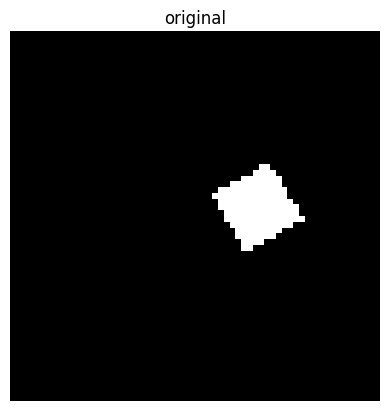

tensor([[ 0,  0,  1, 13, 26, 14]])


In [2]:
import io    #A
import urllib.request    #A
from matplotlib import pyplot as plt
import numpy as np    #A
import torch

url = 'https://github.com/altdeep/causalML/blob/master/book/chapter%208/sprites_example.npz?raw=true'    #A
with urllib.request.urlopen(url) as response:    #A
    data = response.read()    #A
file = io.BytesIO(data)    #A
npzfile = np.load(file)    #A
img_dict = dict(npzfile)    #A
img = torch.tensor(img_dict['image'].astype(np.float32) )   #B
plt.imshow(img, cmap='Greys_r', interpolation='nearest')    #B
plt.axis('off')    #B
plt.title('original')    #B
plt.show()    #B
causal_factor = torch.from_numpy(img_dict['label']).unsqueeze(0)    #C
print(causal_factor)    #C

#A Download sprites example from GitHub and load it.
#B Download the sprites image.
#C The causal factors of the example is [0  0  1 13 26 14], the first element is always 0, the second element corresponds to "square" and is represented by 0. The remaining elements correspond to scale, orientation, and X and Y positions.

## Load the encoder of causal factors

In [3]:
import requests
import torch.nn as nn

class EncoderCausalFactors(nn.Module):    #A
  def __init__(self, image_dim, factor_dim):
    super(EncoderCausalFactors, self).__init__()
    self.image_dim = image_dim
    self.factor_dim = factor_dim
    hidden_dim = 1000    #B
    self.fc1 = nn.Linear(image_dim, hidden_dim)    #C
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)    #C
    self.fc3 = nn.Linear(hidden_dim, factor_dim)    #C
    self.softplus = nn.Softplus()    #C
    self.sigmoid = nn.Sigmoid()    #D

  def forward(self, img):
    img = img.reshape(-1, self.image_dim)    #E
    hidden1 = self.softplus(self.fc1(img))    #F
    hidden2 = self.softplus(self.fc2(hidden1))    #F
    p_loc = self.sigmoid(self.fc3(hidden2))    #G
    return p_loc    #G

encoder_n_causal_factors = EncoderCausalFactors(    #H
    image_dim=64*64,    #H
    factor_dim=sum([1,3,6,40,32,32])    #H
)

url = 'https://github.com/altdeep/causalML/raw/master/book/chapter%208/sprites-model-encoder-causal-factors.pt'    #I
response = requests.get(url)    #I
response.raise_for_status()    #I
with open('temp_weights.pt', 'wb') as f:    #I
    f.write(response.content)    #I
state_dict = torch.load(    #I
    'temp_weights.pt',    #I
    map_location=torch.device('cpu')    #I
)    #I
encoder_n_causal_factors.load_state_dict(state_dict)    #I
#A Encoder for the the vector of exogenous parents of the causal factors.
#B The hidden layers have a length of 1000
#C Using a linear transforms passed through softplus activation functions.
#D The final activation is a sigmoid function.
#E Flatten the image.
#F Calculate the hidden layers.
#G The output layer generates a probability vector passed OneHotCategorical distribution.
#H Initialize the encoder. The image dimension is 64x64 pixels, the six elements of the causal factor vector are one-hot encoded into a vector of length 1+3+6+40+32+32=114
#I Download the pre-trained weights to a temporary file and load them into the model.  You can download the weights from 'https://github.com/altdeep/causalML/blob/master/book/chapter%208/sprites-model-encoder-causal-factors.pt?raw=true'

<All keys matched successfully>

## Generate examples of causal exogenous factors

In [4]:
from pyro import distributions as dist

CARDINALITY = [1, 3, 6, 40, 32, 32]    #A

def decode_one_hot(factor_encoded, cardinality=CARDINALITY):    #B
    split = [    #B
        torch.split(element, cardinality)     #B
        for element in factor_encoded    #B
    ]    #B
    labels = [[int(torch.argmax(vec)) for vec in item] for item in split] #B
    return torch.tensor(labels)    #B

def sample_one_hot(p_encoded, cardinality=CARDINALITY):    #C
    split = [torch.split(element, cardinality) for element in p_encoded]    #C
    sample_list = [    #C
        [    #C
            dist.OneHotCategorical(p_vec).sample()    #C
            for p_vec in item    #C
        ] for item in split    #C
    ]    #C
    sample = torch.stack([    #C
        torch.cat(samples, -1)    #C
        for samples in sample_list    #C
    ])    #C
    return sample    #C

inferred_cause_p = encoder_n_causal_factors.forward(img)    #D
sampled_factors = sample_one_hot(    #D
    inferred_cause_p    #D
)    #D
print(decode_one_hot(sampled_factors))    #D

#A Set the cardinality of the causal factor vector.
#B Helper function that decodes the one-hot encoded output of the encoder.
#C Samples from the output probability vector of the encoder_causal_factors.
#D Use encoder to predict causal factors.

tensor([[ 0,  0,  1, 13, 26, 14]])




## An encoder for inference of $N_I$

In [5]:
class EncoderNImage(nn.Module):    #A
  def __init__(self, image_dim, factor_dim, n_image_dim):
    super(EncoderNImage, self).__init__()
    self.image_dim = image_dim
    self.factor_dim = factor_dim
    self.n_image_dim = n_image_dim
    hidden_dim = 1000
    self.fc1 = nn.Linear(
        self.image_dim + self.factor_dim, hidden_dim    #B
    )    #B
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)    #B
    self.fc31 = nn.Linear(hidden_dim, n_image_dim)    #B
    self.fc32 = nn.Linear(hidden_dim, n_image_dim)    #B
    self.softplus = nn.Softplus()    #B

  def forward(self, img, factor):
    img = img.reshape(-1, self.image_dim)    #C
    inputs = torch.cat((img, factor), -1)    #D
    hidden1 = self.softplus(self.fc1(inputs))    #E
    hidden2 = self.softplus(self.fc2(hidden1))    #E
    n_image_loc = self.fc31(hidden2)    #F
    n_image_scale = torch.exp(self.fc32(hidden2))    #F
    return n_image_loc, n_image_scale    #F

def encode_one_hot(factor, cardinality=CARDINALITY):    #G
    new_factor = []    #G
    for i, factor_length in enumerate(cardinality):    #G
        new_factor.append(    #G
            torch.nn.functional.one_hot(    #G
                factor[:,i].to(torch.int64), int(factor_length)    #G
            )    #G
        )    #G
    new_factor = torch.cat(new_factor, -1)    #G
    return new_factor.to(torch.float32)    #G

encoder_n_image = EncoderNImage(    #H
    image_dim=64*64,    #H
    factor_dim=sum(CARDINALITY),    #H
    n_image_dim=50    #H
)    #H
url = "https://github.com/altdeep/causalML/raw/master/book/chapter%208/sprites-model-encoder-n-image.pt"    #I
response = requests.get(url)    #I
response.raise_for_status()    #I
with open('temp_weights.pt', 'wb') as f:    #I
    f.write(response.content)    #I
state_dict = torch.load(    #I
    'temp_weights.pt',    #I
    map_location=torch.device('cpu')    #I
)    #I
encoder_n_image.load_state_dict(state_dict)    #I

n_image_loc, n_image_scale = encoder_n_image.forward(    #J
    img,    #J
    encode_one_hot(causal_factor)    #J
)    #J
n_image = torch.normal(n_image_loc, n_image_scale)    #K

#A Encoder for NI, which serves as both the exogenous variable for the image in causal terms, and the encoding of the image in VAE terms.
#B Using a linear transforms passed into a softplus activation function.
#C Flatten the image.
#D Concatenate the image and the causal factor vector.
#E Calculate the hidden layers.
#F Calculate the location and scale parameter of multivariate normal distribution on N_image.
#G A helper function one-hot encoding a factor.
#H Initialize the encoder.
#H Load the pretrained weights.  The weights are available from https://github.com/altdeep/causalML/blob/master/book/chapter%208/sprites-model-encoder-n-image.pt
#I pass the image and causal factors into the encoder and obtain NI location and scale parameters
#J Generate from the posterior distribution on NI.

## Load and run the decoder that maps causes and $N_I$ to images

In [6]:
class Decoder(nn.Module):    #A
  def __init__(self, image_dim, factor_dim, n_image_dim):
    super(Decoder, self).__init__()
    hidden_dim = 1000
    self.fc1 = nn.Linear(n_image_dim + factor_dim, hidden_dim)    #B
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)    #B
    self.fc3 = nn.Linear(hidden_dim, hidden_dim)    #B
    self.fc4 = nn.Linear(hidden_dim, image_dim)    #B
    self.softplus = nn.Softplus()    #B
    self.sigmoid = nn.Sigmoid()    #B

  def forward(self, n_image, factor):
    inputs = torch.cat((n_image, factor), -1)    #C
    hidden1 = self.softplus(self.fc1(inputs))    #D
    hidden2 = self.softplus(self.fc2(hidden1))    #D
    hidden3 = self.softplus(self.fc3(hidden2))    #D
    p_img = self.sigmoid(self.fc4(hidden3))    #E
    return p_img    #E

decoder = Decoder(    #F
    image_dim=64*64,    #F
    factor_dim=sum(CARDINALITY),    #F
    n_image_dim=50    #F
)    #F

url = "https://github.com/altdeep/causalML/raw/master/book/chapter%208/sprites-model-decoder.pt"    #G
response = requests.get(url)    #G
response.raise_for_status()    #G
with open('temp_weights.pt', 'wb') as f:    #G
    f.write(response.content)    #G
state_dict = torch.load(    #G
    'temp_weights.pt',    #G
    map_location=torch.device('cpu')    #G
)    #G
decoder.load_state_dict(state_dict)    #G

#A The decoder maps from causal factors and N_image to generate a parameter for a multivariate Bernoulli distribution on images.
#B The model uses linear transforms, a softplus activate for hidden layers, and sigmoid activate on the output layer.
#C The network concatenates n_image and factors in the input layer.
#D The input is passed through three hidden layers with softplus activation functions.
#E The output is a probability parameter passed to a multivariate Bernoulli distribution on image pixels.
#F Initialize the decoder.
#G Load the pretrained weights.  The weights are available at https://github.com/altdeep/causalML/blob/master/book/chapter%208/sprites-model-decoder.pt

<All keys matched successfully>

## Helper function for plotting counterfactual image

In [7]:
def compare_reconstruction(original, generated):    #A
    fig = plt.figure()    #A
    ax0 = fig.add_subplot(121)    #A
    plt.imshow(    #A
        original.cpu().reshape(64, 64),    #A
        cmap='Greys_r',    #A
        interpolation='nearest'    #A
    )    #A
    plt.axis('off')    #A
    plt.title('actual')    #A
    ax1 = fig.add_subplot(122)    #A
    plt.imshow(    #A
        generated.reshape(64, 64),    #A
        cmap='Greys_r', interpolation='nearest')    #A
    plt.axis('off')    #A
    plt.title('counterfactual')    #A
    plt.show()    #A

#A The help function plots the original and counterfactual image side-by-side

## Create exogenous distribution and assignment function for the image

In [8]:
def p_n_image(n_image_params):    #A
    n_image_loc, n_image_scale, n_unif_upper = n_image_params    #B
    n_image_norm = dist.Normal(n_image_loc, n_image_scale).to_event(1).sample()    #C
    n_image_unif = dist.Uniform(0, n_unif_upper).expand(    #D
        torch.Size([1, 64*64])    #D
    ).sample()    #D
    n_image = n_image_norm, n_image_unif    #E
    return n_image

def f_image(factor, n_image):    #F
    n_image_norm, n_image_unif = n_image    #G
    p_output = decoder.forward(    #H
        n_image_norm,    #H
        encode_one_hot(factor)    #H
    )    #H
    sim_img = (n_image_unif <= p_output).int()    #I
    return sim_img

#A A function that generates a variate from the N_image exogenous distribution.
#B The parameters the N_image's distribution include location and scale parameter for a normal distribution, and the upper bound of a uniform distribution.
#C Sample a normal random variate from the Normal distribution.
#D Sample a uniform random variate from a Uniform distribution.
#E We combine these into a single n_image object.
#F Assignment function for the image.
#G The exogenous noise variable decomposes into a normal random variable and a uniform random variate.
#H the normal random variable is passed through the decoder to get a probability vector for the pixels.
#I Each pixel is set deterministically with an indicator function that returns 1 if an element of the uniform variate is less than the corresponding element of the probability vector, or otherwise returns 0.

## Generate a counterfactual image

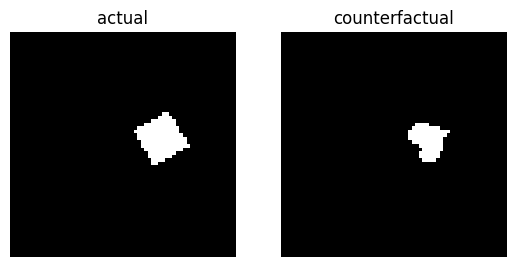

In [12]:
def abduct(img, factor, smoother=1e-3):    #A
    n_image_loc, n_image_scale = encoder_n_image.forward(    #B
        img, encode_one_hot(factor)    #B
    )    #B
    n_unif_upper = decoder.forward(    #C
        n_image_loc,    #C
        encode_one_hot(factor)    #C
    )    #C
    n_unif_upper = n_unif_upper * (1 - 2 * smoother) + smoother    #C
    p_image_params = n_image_loc, n_image_scale, n_unif_upper    #D
    return p_image_params

def do_action(factor, element=1, val=2):    #E
    intervened_factor = factor.clone()    #E
    intervened_factor[0][element] = val    #E
    return intervened_factor    #E

def predict(intervened_factor, n_image_params):    #F
    n_image = p_n_image(n_image_params)    #F
    sim_img = f_image(intervened_factor, n_image)    #F
    return sim_img    #F

def counterfactual(img, factor):    #G
    p_image_params = abduct(img, factor)    #G
    intervened_factor = do_action(factor)    #G
    pred_recon = predict(intervened_factor, p_image_params)    #G
    compare_reconstruction(img, pred_recon)    #G

counterfactual(img, causal_factor)    #H

#A Abduction step: Infer the exogenous variable given the image.
#B Infer the parameters of N_I. First, this includes two parameters of a normal distribution.
#C Secondly, we infer the upper bound of a uniform distribution and apply smoothing so it is not exactly 1 or 0.
#D Combine these together into one inferred parameter set.
#E Action step: Apply the intervention that sets the shape element to "heart" (represented by the integer 2).
#F Prediction step: Generate n_image from P(N_image), pass this through assignment function to generate an image.
#G Apply all three steps, "abduct" the n_image, apply the intervention, forward generate the counterfactual image.
#H Plot the result.